# Imports

In [2]:
import time
import warnings
import numpy as np
import arff
import pandas as pd
import scipy as sp
import networkx as nx
import os
import struct
import skdim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sklearn.datasets as skdata
import repliclust
import sklearn.neighbors as sknn
from numpy import sqrt
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import calinski_harabasz_score
from umap import UMAP                 
import json
from PIL import Image
from kisomap import KIsomap, Clustering, PlotaDados
import sys
from skimage.util import random_noise
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# To avoid unnecessary warning messages
warnings.simplefilter(action='ignore')

Failed to initialize OpenAI client. Either put OPENAI_API_KEY=<...> into the .env file or pass openai_api_key=<...> as an argument in a function call.


In [5]:
sys.path.append('C:/Users/Gustavo/Documents/Mestrado/curvature-based-isomap/kisomap-functions')

# Gaussian Dataset

Data saved to repliclust_data.csv


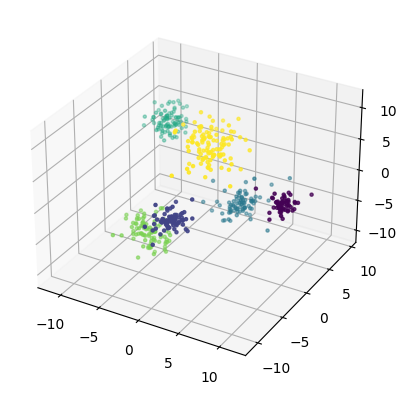

In [3]:
# Gaussian Dataset
archetype = repliclust.Archetype(
                    dim=3,
                    n_samples=500,
                    max_overlap=0.00001, min_overlap=0.000004 ,name="oblong"
                    )
X1, y1, _ = (repliclust.DataGenerator(archetype).synthesize(quiet=True))

X1 = X1.astype(np.float64)

# Parameters
noise_scale = 1  # adjust the noise gaussian parameter here

# Add noise
# Definir a magnitude do ruído gaussiano
magnitude = np.linspace(0,1,26)
# Gerar ruído gaussiano com média zero e desvio padrão baseado na magnitude
ruido = np.random.normal(0, scale=magnitude[0], size=X1.shape)
# Adicionar o ruído aos dados
# Surface equation
X1.T[0] = X1.T[0] + ruido.T[0]
X1.T[1] = X1.T[1] + ruido.T[1]
X1.T[2] = X1.T[2] + ruido.T[2]

# Create DataFrame with x, y, z and label
df = pd.DataFrame({
    'x': X1[:, 0],  # First column of X1
    'y': X1[:, 1],  # Second column of X1
    'z': X1[:, 2],  # Third column of X1
    'label': y1     # Label data
})

# Save DataFrame to CSV
df.to_csv('repliclust_data.csv', index=False)

print("Data saved to repliclust_data.csv")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(X1.T[0], X1.T[1], X1.T[2], c=y1, marker='.')

# Pen Digits 

In [2]:
# Reading .tra file
train_data = pd.read_csv('C:/Users/Gustavo/Documents/Mestrado/curvature-based-isomap/datasets/pen-digits/pendigits.tra',header=None)  # Add parameters as needed
print(train_data.head())

# Reading .tes file
test_data = pd.read_csv('C:/Users/Gustavo/Documents/Mestrado/curvature-based-isomap/datasets/pen-digits/pendigits.tes',header=None)  # Add parameters as needed
print(test_data.head())

   0    1   2    3    4    5    6    7   8   9    10  11   12  13   14  15  16
0  47  100  27   81   57   37   26    0   0  23   56  53  100  90   40  98   8
1   0   89  27  100   42   75   29   45  15  15   37   0   69   2  100   6   2
2   0   57  31   68   72   90  100  100  76  75   50  51   28  25   16   0   1
3   0  100   7   92    5   68   19   45  86  34  100  45   74  23   67   0   4
4   0   67  49   83  100  100   81   80  60  60   40  40   33  20   47   0   1
   0    1   2    3   4   5    6   7    8   9    10  11   12   13   14   15  16
0  88   92   2   99  16  66   94  37   70   0    0  24   42   65  100  100   8
1  80  100  18   98  60  66  100  29   42   0    0  23   42   61   56   98   8
2   0   94   9   57  20  19    7   0   20  36   70  68  100  100   18   92   8
3  95   82  71  100  27  77   77  73  100  80   93  42   56   13    0    0   9
4  68  100   6   88  47  75   87  82   85  56  100  29   75    6    0    0   9


In [3]:
# Separando dados e rótulos no conjunto de treino
X_train = train_data.iloc[:, :-1]  # Todas as colunas exceto a última
y_train = train_data.iloc[:, -1]   # Apenas a última coluna

# Separando dados e rótulos no conjunto de teste
X_test = test_data.iloc[:, :-1]    # Todas as colunas exceto a última
y_test = test_data.iloc[:, -1]     # Apenas a última coluna

In [4]:
pen_digits = {'data': X_train, 'target': y_train, 'details': {'name':'Pen-Digits'}}

# Mnist

In [2]:
def read_idx1_ubyte(file_path):
    with open(file_path, 'rb') as file:
        magic_number = struct.unpack('>I', file.read(4))[0]
        if magic_number != 2049:
            raise ValueError(f"Invalid magic number {magic_number} in file {file_path}")
        num_items = struct.unpack('>I', file.read(4))[0]
        labels = np.frombuffer(file.read(), dtype=np.uint8)
        if labels.size != num_items:
            raise ValueError("Mismatch in label count")
        return labels

def read_idx3_ubyte(file_path):
    with open(file_path, 'rb') as file:
        magic_number = struct.unpack('>I', file.read(4))[0]
        if magic_number != 2051:
            raise ValueError(f"Invalid magic number {magic_number} in file {file_path}")
        
        num_images = struct.unpack('>I', file.read(4))[0]
        num_rows = struct.unpack('>I', file.read(4))[0]
        num_cols = struct.unpack('>I', file.read(4))[0]
        
        images = np.frombuffer(file.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
        return images

labels_path = r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\mnist\train-labels.idx1-ubyte'
images_path = r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\mnist\train-images.idx3-ubyte'  # Substitua pelo caminho do seu arquivo

labels = read_idx1_ubyte(labels_path)
images = read_idx3_ubyte(images_path)

In [6]:
images.shape

(60000, 784)

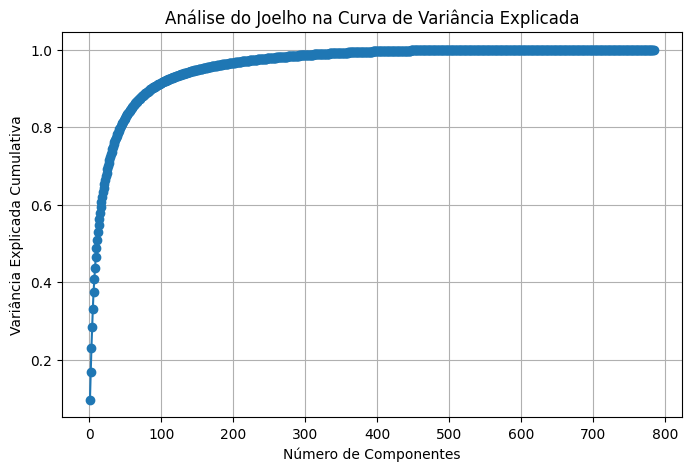

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Supondo que seu DataFrame seja chamado 'data'
# Certifique-se de substituir 'data' pelo nome real do seu DataFrame
X = images

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()


In [3]:
mnist = {'data': images, 'target': labels, 'details': {'name':'MNIST'}}

In [12]:
labels.shape

(60000,)

# F-mnist

In [2]:
# Reading .tra file
train_data = pd.read_csv(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\f-mnist\fashion-mnist_train.csv')  # Add parameters as needed

# Reading .tes file
test_data = pd.read_csv(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\f-mnist\fashion-mnist_test.csv')  # Add parameters as needed

In [9]:
train_data.iloc[:,1:].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [3]:
fmnist = {'data': train_data.iloc[:,1:].values, 'target': train_data['label'].values, 'details': {'name':'F-MNIST'}}

# Coil-20

In [11]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_num in range(1, 21):  # Pastas numeradas de 1 a 20
        class_folder = os.path.join(folder, str(class_num))
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    img = Image.open(img_path).convert('L')  # Converter para escala de cinza
                    img_array = np.array(img).flatten()  # Flatten a imagem
                    images.append(img_array)
                    labels.append(class_num)
    return np.array(images), np.array(labels)

def create_dataframe(images, labels):
    data = np.column_stack((images, labels))
    columns = [f'pixel_{i}' for i in range(images.shape[1])] + ['label']
    df = pd.DataFrame(data, columns=columns)
    return df

folder_path = r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\coil-20'  # Substitua pelo caminho da sua pasta principal
images, labels = load_images_from_folder(folder_path)
dataset_df = create_dataframe(images, labels)

# Salvar o dataset em um arquivo CSV
dataset_df.to_csv('dataset_coil-20.csv', index=False)

In [12]:
dataset_df.iloc[:, -1]

0        1
1        1
2        1
3        1
4        1
        ..
1435    20
1436    20
1437    20
1438    20
1439    20
Name: label, Length: 1440, dtype: int32

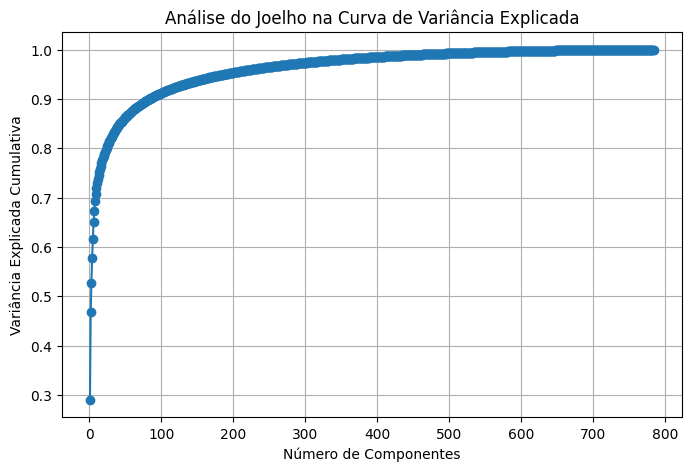

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Supondo que seu DataFrame seja chamado 'data'
# Certifique-se de substituir 'data' pelo nome real do seu DataFrame
X = train_data.iloc[:,1:]

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()


In [13]:
coil_20 = {'data': dataset_df.iloc[:, :-1].values, 'target': dataset_df.iloc[:, -1].values, 'details': {'name':'coil-20'}}

# AP_Omentum_Kidney

In [14]:
from scipy.io import arff
import pandas as pd

# Carregar o arquivo ARFF
data, meta = arff.loadarff(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\AP_Omentum_Kidney\AP_Omentum_Kidney.arff')

# Converter para um DataFrame do pandas
df = pd.DataFrame(data)

In [15]:

labels = df['Tissue']

dataset = df.drop(['Tissue'],axis=1)

In [16]:
omentum_kidney = {'data': dataset, 'target': labels, 'details': {'name':'AP_Omentum_Kidney'}}

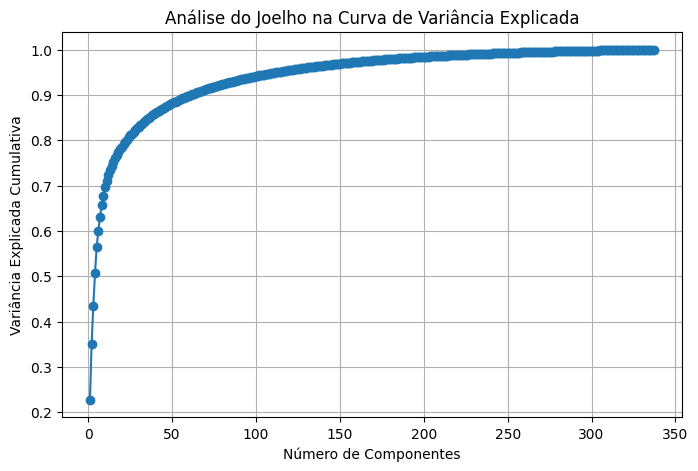

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Supondo que seu DataFrame seja chamado 'data'
# Certifique-se de substituir 'data' pelo nome real do seu DataFrame
X = dataset

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()

# Olivetti-Faces

In [17]:
from sklearn.datasets import fetch_olivetti_faces
olivetti_faces = fetch_olivetti_faces()
olivetti_faces.data.shape

(400, 4096)

In [18]:
olivetti = {'data': olivetti_faces.data, 'target': olivetti_faces.target, 'details': {'name':'olivetti-faces'}}

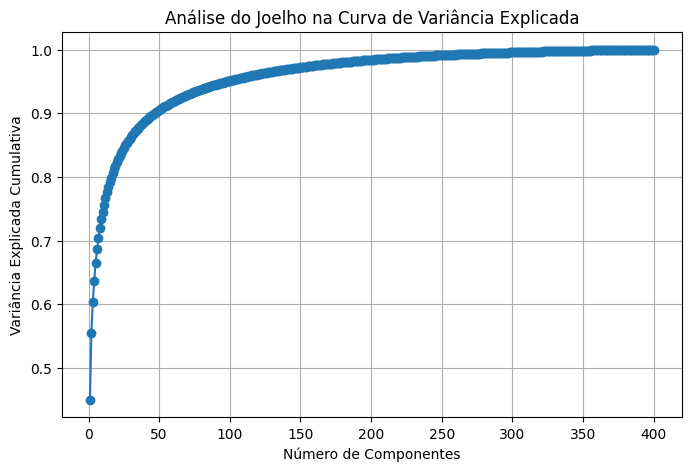

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Supondo que seu DataFrame seja chamado 'data'
# Certifique-se de substituir 'data' pelo nome real do seu DataFrame
X = olivetti_faces['data'].T

# Aplicar PCA
pca = PCA()
pca.fit(X)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotar a curva de variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Análise do Joelho na Curva de Variância Explicada')
plt.grid()
plt.show()

# Magic Telescope

In [11]:
from scipy.io import arff

data, meta = arff.loadarff(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\datasets\magic-telescope\dataset')
df = pd.DataFrame(data)

magic_telescope = {'data':df.iloc[:,:-1].values,'target':df.iloc[:,-1:].values,'details': {'name':'magic-telescope'}}

# 2nd Revision Results

In [2]:
# Função para normalizar os dados
def normalize_metrics(metrics_dict):
    normalized_metrics = {}
    for metric, methods in metrics_dict.items():
        # Concatenar todos os dados
        all_data = np.concatenate([methods[method] for method in methods])
        # Normalizar dados
        min_val, max_val = np.min(all_data), np.max(all_data)
        all_data_normalized = (all_data - min_val) / (max_val - min_val)
        # Atualizar dicionário com dados normalizados
        start = 0
        for method in methods:
            end = start + len(methods[method])
            normalized_metrics.setdefault(metric, {})[method] = all_data_normalized[start:end].tolist()
            start = end
    return normalized_metrics

#####################  Data loading
    
#To perform the experiments according to the article, uncomment the desired sets of datasets
datasets = [# First set of experiments
    {"db": skdata.fetch_openml(name='servo', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='car-evaluation', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='breast-tissue', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='Engine1', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='xd6', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='heart-h', version=3), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='steel-plates-fault', version=3), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='PhishingWebsites', version=1), "reduce_samples": True, "percentage":.1, "reduce_dim":False, "num_features": 0},           # 10% of the samples
    {"db": skdata.fetch_openml(name='satimage', version=1), "reduce_samples": True, "percentage":.25, "reduce_dim":False, "num_features": 0},                  # 25% of the samples
    {"db": skdata.fetch_openml(name='led24', version=1), "reduce_samples": True, "percentage":.25, "reduce_dim":False, "num_features": 0},                     # 25% of the samples
    {"db": skdata.fetch_openml(name='hayes-roth', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='rabe_131', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='prnn_synth', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='visualizing_environmental', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='diggle_table_a2', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='newton_hema', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='wisconsin', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='conference_attendance', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='tic-tac-toe', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='qsar-biodeg', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='spambase', version=1), "reduce_samples": True, "percentage":.25, "reduce_dim":False, "num_features": 0},                  # 25% of the samples
    {"db": skdata.fetch_openml(name='cmc', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    {"db": skdata.fetch_openml(name='heart-statlog', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0}]
    
    
    #Second set of experiments
    #{"db": skdata.fetch_openml(name='cnae-9', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 50},                     # 50-D
    #{"db": skdata.fetch_openml(name='AP_Breast_Kidney', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 500},          # 500-D
    #{"db": skdata.fetch_openml(name='AP_Endometrium_Breast', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 400},     # 400-D
    #{"db": skdata.fetch_openml(name='AP_Ovary_Lung', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 100},             # 100-D
    #{"db": skdata.fetch_openml(name='OVA_Uterus', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 100},                # 100-D
    #{"db": skdata.fetch_openml(name='micro-mass', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 100},                # 100-D
    #{"db": skdata.fetch_openml(name='har', version=1), "reduce_samples": True, "percentage":0.1, "reduce_dim":True, "num_features": 100},                      # 100-D and 10%  of the samples and 
    #{"db": skdata.fetch_openml(name='eating', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 100},                    # 100-D
    #{"db": skdata.fetch_openml(name='oh5.wc', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 40},                     # 40-D
    #{"db": skdata.fetch_openml(name='leukemia', version=1), "reduce_samples": False, "percentage":0, "reduce_dim":True, "num_features": 40},                  # 40-D
    #{"db": skdata.fetch_openml(name='fri_c4_250_100', version=2), "reduce_samples": False, "percentage":0, "reduce_dim":False, "num_features": 0},
    #{"db": magic_telescope, "reduce_samples": True, "percentage":0.5, "reduce_dim":False, "num_features":0},                             # 50% of the samples
    #{"db": omentum_kidney, "reduce_samples": False, "percentage":0.5, "reduce_dim":True, "num_features":100},                                                   # 20-D
    #{"db": olivetti, "reduce_samples": False, "percentage":0.5, "reduce_dim":True, "num_features":100},                                                            # 100-D
    #{"db": coil_20, "reduce_samples": False, "percentage":0.2, "reduce_dim":True, "num_features":200},                                                          # 100-D 10% of the samples
    #{"db": pen_digits, "reduce_samples": False, "percentage":0.1, "reduce_dim":False, "num_features":0}]                                                       
    #{"db": mnist, "reduce_samples": True, "percentage":0.1, "reduce_dim":True, "num_features":200}]                                                          # 200-D and 10% of the samples
    #{"db": fmnist, "reduce_samples": True, "percentage":0.1, "reduce_dim":True, "num_features":200}]                                                           # 200-D and 10% of the samples
    


plot_results = False
apply_noise = False

# ['gaussian', 'salt_pepper', 'poison']
noise_type = 'gaussian'

if apply_noise:
    # Noise parameters
    # Standard deviation (spread or “width”) of the distribution. Must be non-negative
    data_std_dev = 1 # for normalized data base
    
    # Define magnitude
    magnitude = np.linspace(0, data_std_dev, 11)
else:
    magnitude = np.linspace(0, 0, 1)

# File result
results = {}
for dataset in datasets:
    
    X = dataset["db"]
    raw_data = X['data']
    dataset_data = X['data']
    dataset_target = X['target']
    dataset_name = X['details']['name']
    # Convert labels to integers
    label_list = []
    for x in dataset_target:
        if x not in label_list:  
            label_list.append(x)     
            
    # Map labels to respective numbers
    labels = []
    for x in dataset_target:  
        for i in range(len(label_list)):
            if x == label_list[i]:  
                labels.append(i)
    dataset_target = np.array(labels)

    # Number of samples, features and classes
    n = dataset_data.shape[0]
    m = dataset_data.shape[1]
    c = len(np.unique(dataset_target))

    # Some adjustments are require in opnML datasets
    # Categorical features must be encoded manually
    if type(dataset_data) == sp.sparse._csr.csr_matrix:
        dataset_data = dataset_data.todense()
        dataset_data = np.asarray(dataset_data)
    if not isinstance(dataset_data, np.ndarray):
        cat_cols = dataset_data.select_dtypes(['category']).columns
        dataset_data[cat_cols] = dataset_data[cat_cols].apply(lambda x: x.cat.codes)
        # Convert to numpy
        dataset_data = dataset_data.to_numpy()

    # To remove NaNs
    dataset_data = np.nan_to_num(dataset_data)
    # Data standardization (to deal with variables having different units/scales)
    dataset_data = preprocessing.scale(dataset_data).astype(np.float64)

    # OPTIONAL: set this flag to True to reduce the number of samples
    reduce_samples = dataset["reduce_samples"]
    reduce_dim = dataset["reduce_dim"]

    if not reduce_samples and not reduce_dim:
        raw_data = dataset_data
    if reduce_samples:
        percentage = dataset["percentage"]
        dataset_data, garbage, dataset_target, garbage_t = train_test_split(dataset_data, dataset_target, train_size=percentage, random_state=42)
        raw_data = dataset_data
    if reduce_dim:
        num_features = dataset["num_features"]
        raw_data = dataset_data
        dataset_data = PCA(n_components=num_features).fit_transform(dataset_data)

    # Number of samples, features and classes
    n = dataset_data.shape[0]
    m = dataset_data.shape[1]
    
    ######## INTRINSIC DIMENSION ESTIMATION
    # Estimate global intrinsic dimension with MLE - Levina & Bickel
    MLE = skdim.id.MLE().fit(dataset_data)
    # Get estimated intrinsic dimension
    if int(np.floor(MLE.dimension_)) == 0 or int(np.floor(MLE.dimension_)) == 1:
        d_star = 2
    else: 
        d_star = int(np.floor(MLE.dimension_)) 

    # Print data info
    print(dataset_name)
    print('N = ', n)
    print('M = ', m)
    print('C = %d' %c)
    print('D = %d' %d_star)
    
    # Number of neighbors in KNN graph (patch size)
    #nn = round(sqrt(n))     
    nn = 40            
   
    # K-ISOMAP results
    ri_kiso, ch_kiso, fm_kiso, v_kiso, s_kiso, db_kiso, ac_kiso = [], [], [], [], [], [], []
    ch_kiso_norm, ri_kiso_norm, fm_kiso_norm, v_kiso_norm, s_kiso_norm, db_kiso_norm = [], [], [], [], [], []
    ri_best_metric, ch_best_metric, fm_best_metric, v_best_metric, s_best_metric, db_best_metric, ac_best_metric = [], [], [], [], [], [], []


    # ISOMAP results
    ri_iso, ch_iso, fm_iso, v_iso, s_iso, db_iso, ac_iso= [], [], [], [], [], [], []
    ri_iso_norm, ch_iso_norm, fm_iso_norm, v_iso_norm, s_iso_norm, db_iso_norm = [], [], [], [], [], []


    # UMAP results
    ri_umap, ch_umap, fm_umap, v_umap, s_umap, db_umap, ac_umap = [], [], [], [], [], [], []
    ri_umap_norm, ch_umap_norm, fm_umap_norm, v_umap_norm, s_umap_norm, db_umap_norm = [], [], [], [], [], []


    # RAW results
    ri_raw, ch_raw, fm_raw, v_raw, s_raw, db_raw, ac_raw = [], [], [], [], [], [], []
    ri_raw_norm, ch_raw_norm, fm_raw_norm, v_raw_norm, s_raw_norm, db_raw_norm = [], [], [], [], [], []

    # Kernel PCA results
    ri_kpca, ch_kpca, fm_kpca, v_kpca, s_kpca, db_kpca, ac_kpca = [], [], [], [], [], [], []
    ri_kpca_norm, ch_kpca_norm, fm_kpca_norm, v_kpca_norm, s_kpca_norm, db_kpca_norm = [], [], [], [], [], []
    
    # t-SNE results
    ri_tsne, ch_tsne, fm_tsne, v_tsne, s_tsne, db_tsne, ac_tsne = [], [], [], [], [], [], []
    ri_tsne_norm, ch_tsne_norm, fm_tsne_norm, v_tsne_norm, s_tsne_norm, db_tsne_norm = [], [], [], [], [], []
    
    # LLE Eigenmaps results
    ri_laplacian, ch_laplacian, fm_laplacian, v_laplacian, s_laplacian, db_laplacian, ac_laplacian = [], [], [], [], [], [], []
    ri_laplacian_norm, ch_laplacian_norm, fm_laplacian_norm, v_laplacian_norm, s_laplacian_norm, db_laplacian_norm = [], [], [], [], [], []

    # LLE results
    ri_LLE, ch_LLE, fm_LLE, v_LLE, s_LLE, db_LLE, ac_LLE = [], [], [], [], [], [], []
    ri_LLE_norm, ch_LLE_norm, fm_LLE_norm, v_LLE_norm, s_LLE_norm, db_LLE_norm = [], [], [], [], [], []



    dataset_data_copy = dataset_data.copy()

    ########## KISOMAP
    for r in range(len(magnitude)):

        ############ Análise de Ruido
        #print('Execução de ruído: ', magnitude[r], ' para ', dataset_name)
        #if apply_noise:
            #dataset_data = apply_noise_type('gaussian', dataset_data_copy, magnitude[r])
            #raw_data = apply_noise_type('gaussian', dataset_data_copy, magnitude[r])
            #raw data precisa ajustar o stratified

        # Configuração do StratifiedKFold
        #n_splits = 5
        #skf = StratifiedKFold(n_splits=n_splits)
        #skf.get_n_splits(dataset_data, dataset_target)

        
        ########## KISOMAP
        # Computes the results for all 10 curvature based metrics
        start = time.time()
        
        ri_kmeans, ch_kmeans, fm_kmeans, v_kmeans, s_kmeans, db_kmeans = [], [], [], [], [], []
        ri_gmm, ch_gmm, fm_gmm, v_gmm, s_gmm, db_gmm = [], [], [], [], [], []
        ri_ward, ch_ward, fm_ward, v_ward, s_ward, db_ward = [], [], [], [], [], []

        for i in range(11):
            DR_method = 'K-ISOMAP' 
            try:
                dados_kiso = KIsomap(dataset_data, nn, d_star, i)  
                print("KISOMAP run: ", i)     
            except Exception as e:
                print(DR_method + " -------- def KIsomap error:", e)
                dados_kiso = []
                
            if dados_kiso.any():
                L_kiso = Clustering(dados_kiso.T, dataset_target, DR_method)
                ri_kmeans.append(L_kiso['KMeans']['ri'])
                ch_kmeans.append(L_kiso['KMeans']['ch'])
                fm_kmeans.append(L_kiso['KMeans']['fm'])
                v_kmeans.append(L_kiso['KMeans']['v'])
                s_kmeans.append(L_kiso['KMeans']['s'])
                db_kmeans.append(L_kiso['KMeans']['db'])

                ri_gmm.append(L_kiso['GMM']['ri'])
                ch_gmm.append(L_kiso['GMM']['ch'])
                fm_gmm.append(L_kiso['GMM']['fm'])
                v_gmm.append(L_kiso['GMM']['v'])
                s_gmm.append(L_kiso['GMM']['s'])
                db_gmm.append(L_kiso['GMM']['db'])

                ri_ward.append(L_kiso['Ward']['ri'])
                ch_ward.append(L_kiso['Ward']['ch'])
                fm_ward.append(L_kiso['Ward']['fm'])
                v_ward.append(L_kiso['Ward']['v'])
                s_ward.append(L_kiso['Ward']['s'])
                db_ward.append(L_kiso['Ward']['db'])
        finish = time.time()
        print('K-ISOMAP Result')

        t_kisomap = finish - start
        
        # Find best result in terms of Rand index of metric function
        ri_star_kmeans = max(ri_kmeans,default=0)
        ri_star_gmm = max(ri_gmm,default=0)
        ri_star_ward = max(ri_ward,default=0)

        ri_kiso.append([ri_star_kmeans,ri_star_gmm,ri_star_ward])
        ri_best_metric.append([ri_kmeans.index(ri_star_kmeans),ri_gmm.index(ri_star_gmm),ri_ward.index(ri_star_ward)])
                    
        # Find best result in terms of Calinski-Harabasz Score of metric function
        ch_star_kmeans = max(ch_kmeans, default=0)
        ch_star_gmm = max(ch_gmm, default=0)
        ch_star_ward = max(ch_ward, default=0)

        ch_kiso.append([ch_star_kmeans, ch_star_gmm, ch_star_ward])
        ch_best_metric.append([ch_kmeans.index(ch_star_kmeans), ch_gmm.index(ch_star_gmm), ch_ward.index(ch_star_ward)])

        # Find best result in terms of Fowlkes-Mallows Score of metric function
        fm_star_kmeans = max(fm_kmeans, default=0)
        fm_star_gmm = max(fm_gmm, default=0)
        fm_star_ward = max(fm_ward, default=0)


        fm_kiso.append([fm_star_kmeans, fm_star_gmm, fm_star_ward])
        fm_best_metric.append([fm_kmeans.index(fm_star_kmeans), fm_gmm.index(fm_star_gmm), fm_ward.index(fm_star_ward)])

        # Find best result in terms of V-measure of metric function
        v_star_kmeans = max(v_kmeans, default=0)
        v_star_gmm = max(v_gmm, default=0)
        v_star_ward = max(v_ward, default=0)

        v_kiso.append([v_star_kmeans, v_star_gmm, v_star_ward])
        v_best_metric.append([v_kmeans.index(v_star_kmeans), v_gmm.index(v_star_gmm), v_ward.index(v_star_ward)])

        # Find best result in terms of Silhouette of metric function
        s_star_kmeans = max(s_kmeans, default=0)
        s_star_gmm = max(s_gmm, default=0)
        s_star_ward = max(s_ward, default=0)
   

        s_kiso.append([s_star_kmeans, s_star_gmm, s_star_ward])
        s_best_metric.append([s_kmeans.index(s_star_kmeans), s_gmm.index(s_star_gmm), s_ward.index(s_star_ward)])

        # Find best result in terms of Davies-Bouldin of metric function
        db_star_kmeans = max(db_kmeans, default=0)
        db_star_gmm = max(db_gmm, default=0)
        db_star_ward = max(db_ward, default=0)

        db_kiso.append([db_star_kmeans, db_star_gmm, db_star_ward])
        db_best_metric.append([db_kmeans.index(db_star_kmeans), db_gmm.index(db_star_gmm), db_ward.index(db_star_ward)])
        
        ############## Regular ISOMAP 
        print('ISOMAP result')
        #print('---------------')
        model = Isomap(n_neighbors=nn, n_components=d_star)
        isomap_data = model.fit_transform(dataset_data)
        isomap_data = isomap_data.T
        DR_method = 'ISOMAP' 
        L_iso = Clustering(isomap_data, dataset_target, DR_method)
        ri_iso.append([L_iso['KMeans']['ri'],L_iso['GMM']['ri'],L_iso['Ward']['ri']])
        ch_iso.append([L_iso['KMeans']['ch'],L_iso['GMM']['ch'],L_iso['Ward']['ch']])
        fm_iso.append([L_iso['KMeans']['fm'],L_iso['GMM']['fm'],L_iso['Ward']['fm']])
        v_iso.append([L_iso['KMeans']['v'],L_iso['GMM']['v'],L_iso['Ward']['v']])
        s_iso.append([L_iso['KMeans']['s'],L_iso['GMM']['s'],L_iso['Ward']['s']])
        db_iso.append([L_iso['KMeans']['db'],L_iso['GMM']['db'],L_iso['Ward']['db']])
        
        ############## UMAP
        print('UMAP result')
        #print('---------------')
        model = UMAP(n_components=d_star)
        umap_data = model.fit_transform(dataset_data)
        umap_data = umap_data.T
        DR_method = 'UMAP'
        L_umap = Clustering(umap_data, dataset_target, DR_method)
        ri_umap.append([L_umap['KMeans']['ri'],L_umap['GMM']['ri'],L_umap['Ward']['ri']])
        ch_umap.append([L_umap['KMeans']['ch'],L_umap['GMM']['ch'],L_umap['Ward']['ch']])
        fm_umap.append([L_umap['KMeans']['fm'],L_umap['GMM']['fm'],L_umap['Ward']['fm']])
        v_umap.append([L_umap['KMeans']['v'],L_umap['GMM']['v'],L_umap['Ward']['v']])
        s_umap.append([L_umap['KMeans']['s'],L_umap['GMM']['s'],L_umap['Ward']['s']])
        db_umap.append([L_umap['KMeans']['db'],L_umap['GMM']['db'],L_umap['Ward']['db']])

        # Kernel PCA
        print('Kernel PCA result')
        #print('---------------')
        model = KernelPCA(n_components=d_star, kernel='rbf')
        kpca_data = model.fit_transform(dataset_data)
        kpca_data = kpca_data.T
        DR_method = 'Kernel PCA'
        L_kpca = Clustering(kpca_data, dataset_target, DR_method)
        ri_kpca.append([L_kpca['KMeans']['ri'],L_kpca['GMM']['ri'],L_kpca['Ward']['ri']])
        ch_kpca.append([L_kpca['KMeans']['ch'],L_kpca['GMM']['ch'],L_kpca['Ward']['ch']])
        fm_kpca.append([L_kpca['KMeans']['fm'],L_kpca['GMM']['fm'],L_kpca['Ward']['fm']])
        v_kpca.append([L_kpca['KMeans']['v'],L_kpca['GMM']['v'],L_kpca['Ward']['v']])
        s_kpca.append([L_kpca['KMeans']['s'],L_kpca['GMM']['s'],L_kpca['Ward']['s']])
        db_kpca.append([L_kpca['KMeans']['db'],L_kpca['GMM']['db'],L_kpca['Ward']['db']])

        # t-SNE
        print('t-SNE result')
        #print('---------------')
        model = TSNE(n_components=d_star, random_state=42, method='exact')
        tsne_data = model.fit_transform(dataset_data)
        tsne_data = tsne_data.T
        DR_method = 't-SNE'
        L_tsne = Clustering(tsne_data, dataset_target, DR_method)
        ri_tsne.append([L_tsne['KMeans']['ri'],L_tsne['GMM']['ri'],L_tsne['Ward']['ri']])
        ch_tsne.append([L_tsne['KMeans']['ch'],L_tsne['GMM']['ch'],L_tsne['Ward']['ch']])
        fm_tsne.append([L_tsne['KMeans']['fm'],L_tsne['GMM']['fm'],L_tsne['Ward']['fm']])
        v_tsne.append([L_tsne['KMeans']['v'],L_tsne['GMM']['v'],L_tsne['Ward']['v']])
        s_tsne.append([L_tsne['KMeans']['s'],L_tsne['GMM']['s'],L_tsne['Ward']['s']])
        db_tsne.append([L_tsne['KMeans']['db'],L_tsne['GMM']['db'],L_tsne['Ward']['db']])

        # Laplacian Eigenmaps (Spectral Embedding)
        print('Laplacian Eigenmaps result')
        #print('---------------')
        model = SpectralEmbedding(n_components=d_star)
        laplacian_data = model.fit_transform(dataset_data)
        laplacian_data = laplacian_data.T
        DR_method = 'Laplacian Eigenmaps'
        L_laplacian = Clustering(laplacian_data, dataset_target, DR_method)
        ri_laplacian.append([L_laplacian['KMeans']['ri'],L_laplacian['GMM']['ri'],L_laplacian['Ward']['ri']])
        ch_laplacian.append([L_laplacian['KMeans']['ch'],L_laplacian['GMM']['ch'],L_laplacian['Ward']['ch']])
        fm_laplacian.append([L_laplacian['KMeans']['fm'],L_laplacian['GMM']['fm'],L_laplacian['Ward']['fm']])
        v_laplacian.append([L_laplacian['KMeans']['v'],L_laplacian['GMM']['v'],L_laplacian['Ward']['v']])
        s_laplacian.append([L_laplacian['KMeans']['s'],L_laplacian['GMM']['s'],L_laplacian['Ward']['s']])
        db_laplacian.append([L_laplacian['KMeans']['db'],L_laplacian['GMM']['db'],L_laplacian['Ward']['db']])

        #%%%%%%%%%%% LLE
        print('LLE Result')
        model = LocallyLinearEmbedding(n_neighbors=nn, n_components=d_star)
        LLE_data = model.fit_transform(dataset_data)
        LLE_data = LLE_data.T
        DR_method = 'LLE'
        L_LLE = Clustering(LLE_data, dataset_target, DR_method)
        ri_LLE.append([L_LLE['KMeans']['ri'],L_LLE['GMM']['ri'],L_LLE['Ward']['ri']])
        ch_LLE.append([L_LLE['KMeans']['ch'],L_LLE['GMM']['ch'],L_LLE['Ward']['ch']])
        fm_LLE.append([L_LLE['KMeans']['fm'],L_LLE['GMM']['fm'],L_LLE['Ward']['fm']])
        v_LLE.append([L_LLE['KMeans']['v'],L_LLE['GMM']['v'],L_LLE['Ward']['v']])
        s_LLE.append([L_LLE['KMeans']['s'],L_LLE['GMM']['s'],L_LLE['Ward']['s']])
        db_LLE.append([L_LLE['KMeans']['db'],L_LLE['GMM']['db'],L_LLE['Ward']['db']])

        ############## RAW DATA
        print('RAW result')
        #print('---------------')
        DR_method = 'RAW'
        if reduce_dim:
            L_ = Clustering(dataset_data.T, dataset_target, DR_method)
        else:
            L_ = Clustering(raw_data.T, dataset_target, DR_method)
        ri_raw.append([L_['KMeans']['ri'],L_['GMM']['ri'],L_['Ward']['ri']])
        ch_raw.append([L_['KMeans']['ch'],L_['GMM']['ch'],L_['Ward']['ch']])
        fm_raw.append([L_['KMeans']['fm'],L_['GMM']['fm'],L_['Ward']['fm']])
        v_raw.append([L_['KMeans']['v'],L_['GMM']['v'],L_['Ward']['v']])
        s_raw.append([L_['KMeans']['s'],L_['GMM']['s'],L_['Ward']['s']])
        db_raw.append([L_['KMeans']['db'],L_['GMM']['db'],L_['Ward']['db']])


        
    results[dataset_name] = {
    "KISOMAP": np.array([ri_kiso, ch_kiso, fm_kiso, v_kiso, s_kiso, db_kiso]).tolist(),
    "ISOMAP": np.array([ri_iso, ch_iso, fm_iso, v_iso, s_iso, db_iso]).tolist(),
    "Kernel PCA": np.array([ri_kpca, ch_kpca, fm_kpca, v_kpca, s_kpca, db_kpca]).tolist(),
    "t-SNE": np.array([ri_tsne, ch_tsne, fm_tsne, v_tsne, s_tsne, db_tsne]).tolist(),
    "Laplacian Eigenmaps": np.array([ri_laplacian, ch_laplacian, fm_laplacian, v_laplacian, s_laplacian, db_laplacian]).tolist(),
    "UMAP": np.array([ri_umap, ch_umap, fm_umap, v_umap, s_umap, db_umap]).tolist(),
    "LLE": np.array([ri_LLE, ch_LLE, fm_LLE, v_LLE, s_LLE, db_LLE]).tolist(),
    "RAW": np.array([ri_raw, ch_raw, fm_raw, v_raw, s_raw, db_raw]).tolist()
    }
    
    # NORMALIZE DATA RESULTS
    # Dicionário com todas as métricas e métodos
    metrics_dict = {
        "ri": {
            "kiso": ri_kiso, "iso": ri_iso, "umap": ri_umap, "raw": ri_raw,
            "kpca": ri_kpca, "tsne": ri_tsne, "laplacian": ri_laplacian, "LLE": ri_LLE
        },
        "ch": {
            "kiso": ch_kiso, "iso": ch_iso, "umap": ch_umap, "raw": ch_raw,
            "kpca": ch_kpca, "tsne": ch_tsne, "laplacian": ch_laplacian, "LLE": ch_LLE
        },
        "fm": {
            "kiso": fm_kiso, "iso": fm_iso, "umap": fm_umap, "raw": fm_raw,
            "kpca": fm_kpca, "tsne": fm_tsne, "laplacian": fm_laplacian, "LLE": fm_LLE
        },
        "v": {
            "kiso": v_kiso, "iso": v_iso, "umap": v_umap, "raw": v_raw,
            "kpca": v_kpca, "tsne": v_tsne, "laplacian": v_laplacian, "LLE": v_LLE
        },
        "s": {
            "kiso": s_kiso, "iso": s_iso, "umap": s_umap, "raw": s_raw,
            "kpca": s_kpca, "tsne": s_tsne, "laplacian": s_laplacian, "LLE": s_LLE
        },
        "db": {
            "kiso": db_kiso, "iso": db_iso, "umap": db_umap, "raw": db_raw,
            "kpca": db_kpca, "tsne": db_tsne, "laplacian": db_laplacian, "LLE": db_LLE
        }
    }

    # Normalizar todas as métricas
    normalized_metrics = normalize_metrics(metrics_dict)

    # Atualizar listas de métricas normalizadas
    ri_kiso_norm = normalized_metrics["ri"]["kiso"]
    ri_iso_norm = normalized_metrics["ri"]["iso"]
    ri_umap_norm = normalized_metrics["ri"]["umap"]
    ri_raw_norm = normalized_metrics["ri"]["raw"]
    ri_kpca_norm = normalized_metrics["ri"]["kpca"]
    ri_tsne_norm = normalized_metrics["ri"]["tsne"]
    ri_laplacian_norm = normalized_metrics["ri"]["laplacian"]
    ri_LLE_norm = normalized_metrics["ri"]["LLE"]


    ch_kiso_norm = normalized_metrics["ch"]["kiso"]
    ch_iso_norm = normalized_metrics["ch"]["iso"]
    ch_umap_norm = normalized_metrics["ch"]["umap"]
    ch_raw_norm = normalized_metrics["ch"]["raw"]
    ch_kpca_norm = normalized_metrics["ch"]["kpca"]
    ch_tsne_norm = normalized_metrics["ch"]["tsne"]
    ch_laplacian_norm = normalized_metrics["ch"]["laplacian"]
    ch_LLE_norm = normalized_metrics["ch"]["LLE"]


    fm_kiso_norm = normalized_metrics["fm"]["kiso"]
    fm_iso_norm = normalized_metrics["fm"]["iso"]
    fm_umap_norm = normalized_metrics["fm"]["umap"]
    fm_raw_norm = normalized_metrics["fm"]["raw"]
    fm_kpca_norm = normalized_metrics["fm"]["kpca"]
    fm_tsne_norm = normalized_metrics["fm"]["tsne"]
    fm_laplacian_norm = normalized_metrics["fm"]["laplacian"]
    fm_LLE_norm = normalized_metrics["fm"]["LLE"]


    v_kiso_norm = normalized_metrics["v"]["kiso"]
    v_iso_norm = normalized_metrics["v"]["iso"]
    v_umap_norm = normalized_metrics["v"]["umap"]
    v_raw_norm = normalized_metrics["v"]["raw"]
    v_kpca_norm = normalized_metrics["v"]["kpca"]
    v_tsne_norm = normalized_metrics["v"]["tsne"]
    v_laplacian_norm = normalized_metrics["v"]["laplacian"]
    v_LLE_norm = normalized_metrics["v"]["LLE"]

    s_kiso_norm = normalized_metrics["s"]["kiso"]
    s_iso_norm = normalized_metrics["s"]["iso"]
    s_umap_norm = normalized_metrics["s"]["umap"]
    s_raw_norm = normalized_metrics["s"]["raw"]
    s_kpca_norm = normalized_metrics["s"]["kpca"]
    s_tsne_norm = normalized_metrics["s"]["tsne"]
    s_laplacian_norm = normalized_metrics["s"]["laplacian"]
    s_LLE_norm = normalized_metrics["s"]["LLE"]

    db_kiso_norm = normalized_metrics["db"]["kiso"]
    db_iso_norm = normalized_metrics["db"]["iso"]
    db_umap_norm = normalized_metrics["db"]["umap"]
    db_raw_norm = normalized_metrics["db"]["raw"]
    db_kpca_norm = normalized_metrics["db"]["kpca"]
    db_tsne_norm = normalized_metrics["db"]["tsne"]
    db_laplacian_norm = normalized_metrics["db"]["laplacian"]
    db_LLE_norm = normalized_metrics["db"]["LLE"]


    results[dataset_name + '_norm'] = {
    "KISOMAP": np.array([ri_kiso_norm, ch_kiso_norm, fm_kiso_norm, v_kiso_norm, s_kiso_norm, db_kiso_norm]).tolist(),
    "ISOMAP": np.array([ri_iso_norm, ch_iso_norm, fm_iso_norm, v_iso_norm, s_iso_norm, db_iso_norm]).tolist(),
    "Kernel PCA": np.array([ri_kpca_norm, ch_kpca_norm, fm_kpca_norm, v_kpca_norm, s_kpca_norm, db_kpca_norm]).tolist(),
    "t-SNE": np.array([ri_tsne_norm, ch_tsne_norm, fm_tsne_norm, v_tsne_norm, s_tsne_norm, db_tsne_norm]).tolist(),
    "Laplacian Eigenmaps": np.array([ri_laplacian_norm, ch_laplacian_norm, fm_laplacian_norm, v_laplacian_norm, s_laplacian_norm, db_laplacian_norm]).tolist(),
    "UMAP": np.array([ri_umap_norm, ch_umap_norm, fm_umap_norm, v_umap_norm, s_umap_norm, db_umap_norm]).tolist(),
    "RAW": np.array([ri_raw_norm, ch_raw_norm, fm_raw_norm, v_raw_norm, s_raw_norm, db_raw_norm]).tolist(),
    "LLE": np.array([ri_LLE_norm, ch_LLE_norm, fm_LLE_norm, v_LLE_norm, s_LLE_norm, db_LLE_norm]).tolist()
    }

    # Salvar os resultados em um arquivo JSON (exemplo)
    file_results = 'dataset_results_1st_battery_teste_all.json'

    # Check previous results
    try:
        with open(file_results, 'r') as f:
            previous_results = json.load(f)
    except FileNotFoundError:
        previous_results = {}
        
    results = {key: {**results.get(key, {}), **previous_results.get(key, {})} for key in results.keys() | previous_results.keys()}
    # Save results
    try:
        with open(file_results, 'w') as f:
            json.dump(results, f)
    except IOError as e:
        print(f"An error occurred while writing to the file: {file_results} - {e}")

    print(dataset_name + ' finalizado.')

if plot_results:
    #print('*********************************************')
    #print('******* SUMMARY OF THE RESULTS **************')
    #print('*********************************************')
    #print()
    # Find best result in terms of Rand index
    print('Best K-ISOMAP result in terms of Rand index')
    #print('----------------------------------------------')
    ri_star = max(enumerate(ri_kiso), key=lambda x: x[1])[0]
    dados_kiso = KIsomap(dataset_data, nn, 2, ri_star) 
    L_kiso = Clustering(dados_kiso.T, dataset_target, 'KISOMAP', CLUSTER)
    labels_kiso = L_kiso[6]
    PlotaDados(dados_kiso, labels_kiso, dataset_name + '_KISOMAP_RI', CLUSTER)
    # Find best result in terms of Rand index
    print('Best K-ISOMAP result in terms of Calinski-Harabasz')
    #print('-----------------------------------------------------')
    ch_star = max(enumerate(ch_kiso), key=lambda x: x[1])[0]
    dados_kiso = KIsomap(dataset_data, nn, 2, ch_star) 
    L_kiso = Clustering(dados_kiso.T, dataset_target, 'KISOMAP', CLUSTER)
    labels_kiso = L_kiso[6]
    PlotaDados(dados_kiso, labels_kiso, dataset_name + '_KISOMAP_CH', CLUSTER)
    # Find best result in terms of Fowlkes Mallows
    print('Best K-ISOMAP result in terms of Fowlkes Mallows')
    #print('----------------------------------------------')
    fm_star = max(enumerate(fm_kiso), key=lambda x: x[1])[0]
    dados_kiso = KIsomap(dataset_data, nn, 2, fm_star) 
    L_kiso = Clustering(dados_kiso.T, dataset_target, 'KISOMAP', CLUSTER)
    labels_kiso = L_kiso[6]
    PlotaDados(dados_kiso, labels_kiso, dataset_name + '_KISOMAP_FM', CLUSTER)
    # Find best result in terms of V measure
    print('Best K-ISOMAP result in terms of V measure')
    #print('-----------------------------------------------------')
    v_star = max(enumerate(v_kiso), key=lambda x: x[1])[0]
    dados_kiso = KIsomap(dataset_data, nn, 2, v_star) 
    L_kiso = Clustering(dados_kiso.T, dataset_target, 'KISOMAP', CLUSTER)
    labels_kiso = L_kiso[6]
    PlotaDados(dados_kiso, labels_kiso, dataset_name + '_KISOMAP_V', CLUSTER)
    # Find best result in terms of SC
    print('Best K-ISOMAP result in terms of SC measure')
    #print('-----------------------------------------------------')
    s_star = max(enumerate(s_kiso), key=lambda x: x[1])[0]
    dados_kiso = KIsomap(dataset_data, nn, 2, s_star) 
    L_kiso = Clustering(dados_kiso.T, dataset_target, 'KISOMAP', CLUSTER)
    labels_kiso = L_kiso[6]
    PlotaDados(dados_kiso, labels_kiso, dataset_name + '_KISOMAP_S', CLUSTER)
    # Find best result in terms of DB
    print('Best K-ISOMAP result in terms of DB measure')
    #print('-----------------------------------------------------')
    db_star = max(enumerate(db_kiso), key=lambda x: x[1])[0]
    dados_kiso = KIsomap(dataset_data, nn, 2, db_star) 
    L_kiso = Clustering(dados_kiso.T, dataset_target, 'KISOMAP', CLUSTER)
    labels_kiso = L_kiso[6]
    PlotaDados(dados_kiso, labels_kiso, dataset_name + '_KISOMAP_DB', CLUSTER)
    ############## Regular ISOMAP 
    print('ISOMAP result')
    #print('---------------')
    model = Isomap(n_neighbors=nn, n_components=2)
    isomap_data = model.fit_transform(dataset_data)
    isomap_data = isomap_data.T
    L_iso = Clustering(isomap_data, dataset_target, 'ISOMAP', CLUSTER)
    labels_iso = L_iso[6]
    PlotaDados(isomap_data.T, labels_iso, dataset_name + '_ISOMAP', CLUSTER)
    ############## UMAP
    print('UMAP result')
    #print('---------------')
    model = UMAP(n_components=2)
    umap_data = model.fit_transform(dataset_data)
    umap_data = umap_data.T
    L_umap = Clustering(umap_data, dataset_target, 'UMAP', CLUSTER)
    labels_umap = L_umap[6]
    PlotaDados(umap_data.T, labels_umap, dataset_name + '_UMAP', CLUSTER)
    
    
    # Kernel PCA
    print('Kernel PCA result')
    #print('------------------')
    model = KernelPCA(n_components=2, kernel='rbf')
    kpca_data = model.fit_transform(dataset_data)
    kpca_data = kpca_data.T
    L_kpca = Clustering(kpca_data, dataset_target, 'KPCA', CLUSTER)
    labels_kpca = L_kpca[6]
    PlotaDados(kpca_data.T, labels_kpca, dataset_name + '_KPCA', CLUSTER)
    
    # t-SNE
    print('t-SNE result')
    #print('------------')
    model = TSNE(n_components=3, random_state=42, method='exact')
    tsne_data = model.fit_transform(dataset_data)
    tsne_data = tsne_data.T
    L_tsne = Clustering(tsne_data, dataset_target, 't-SNE', CLUSTER)
    labels_tsne = L_tsne[6]
    PlotaDados(tsne_data.T, labels_tsne, dataset_name + '_t-SNE', CLUSTER)
    
    # Laplacian Eigenmaps (Spectral Embedding)
    print('Laplacian Eigenmaps result')
    #print('--------------------------')
    model = SpectralEmbedding(n_components=d_star)
    laplacian_data = model.fit_transform(dataset_data)
    laplacian_data = laplacian_data.T
    L_laplacian = Clustering(laplacian_data, dataset_target, 'Laplacian Eigenmaps', CLUSTER)
    labels_laplacian = L_laplacian[6]
    PlotaDados(laplacian_data.T, labels_laplacian, dataset_name + '_LaplacianEigenmaps', CLUSTER)
    
    # LLE
    print('LLE result')
    #print('--------------------------')
    model = LocallyLinearEmbedding(n_neighbors=nn, n_components=2)
    LLE_data = model.fit_transform(dataset_data)
    LLE_data = LLE_data.T
    L_LLE = Clustering(LLE_data, dataset_target,'LLE', CLUSTER)
    labels_LLE = L_LLE[6]
    PlotaDados(LLE_data.T, labels_LLE, dataset_name + '_LLE', CLUSTER)

    ############## RAW DATA
    #print('RAW DATA result')
    #print('-----------------')
    #L_ = Clustering(raw_data.T, dataset_target, 'RAW DATA', CLUSTER)
    #labels_ = L_[6]
    #PlotaDados(raw_data.T, labels_, 'RAW DATA')

def gaussian(dataset, scale_mag):
    # Generate noise
    noise = np.random.normal(0, scale=scale_mag, size=dataset.shape)
    # Apply noise in feature level
    dataset_with_noise = dataset.copy() + noise
    return dataset_with_noise

def salt_pepper(dataset, scale_mag):
    # Apply noise salt and pepper
    noise = random_noise(dataset, mode='s&p', amount=scale_mag)
    # Apply noise in feature level
    dataset_with_noise = dataset.copy() + noise
    return dataset_with_noise

#def poison(dataset, scale_mag):
#   return 'poison'

def apply_noise_type(noise_type, dataset, scale_mag):
    #switch = {
    #    'gaussian': gaussian,
    #    'salt_pepper': salt_pepper,
    #    'poison': poison
    #}
    #func = switch.get(noise_type)
    #if func is None:
    #    raise ValueError(f"Invalid noise type: {noise_type}")
    if noise_type == 'gaussian':
        return gaussian(dataset, scale_mag)
    
# Função para normalizar os dados
def normalize_metrics(metrics_dict):
    normalized_metrics = {}
    for metric, methods in metrics_dict.items():
        # Concatenar todos os dados
        all_data = np.concatenate([methods[method] for method in methods])
        # Normalizar dados
        min_val, max_val = np.min(all_data), np.max(all_data)
        all_data_normalized = (all_data - min_val) / (max_val - min_val)
        # Atualizar dicionário com dados normalizados
        start = 0
        for method in methods:
            end = start + len(methods[method])
            normalized_metrics.setdefault(metric, {})[method] = all_data_normalized[start:end].tolist()
            start = end
    return normalized_metrics

servo
N =  167
M =  4
C = 2
D = 3
KISOMAP run:  0
KISOMAP run:  1
KISOMAP run:  2
KISOMAP run:  3
KISOMAP run:  4
KISOMAP run:  5
KISOMAP run:  6
KISOMAP run:  7
KISOMAP run:  8
KISOMAP run:  9
KISOMAP run:  10
K-ISOMAP Result
ISOMAP result
UMAP result
Kernel PCA result
t-SNE result
Laplacian Eigenmaps result
LLE Result
RAW result
servo finalizado.
car-evaluation
N =  1728
M =  21
C = 4
D = 4
KISOMAP run:  0
KISOMAP run:  1
KISOMAP run:  2
KISOMAP run:  3
KISOMAP run:  4
KISOMAP run:  5
KISOMAP run:  6
KISOMAP run:  7
KISOMAP run:  8
KISOMAP run:  9
KISOMAP run:  10
K-ISOMAP Result
ISOMAP result
UMAP result
Kernel PCA result
t-SNE result
Laplacian Eigenmaps result
LLE Result
RAW result
car-evaluation finalizado.
breast-tissue
N =  106
M =  9
C = 4
D = 2
KISOMAP run:  0
KISOMAP run:  1
KISOMAP run:  2
KISOMAP run:  3
KISOMAP run:  4
KISOMAP run:  5
KISOMAP run:  6
KISOMAP run:  7
KISOMAP run:  8
KISOMAP run:  9
KISOMAP run:  10
K-ISOMAP Result
ISOMAP result
UMAP result
Kernel PCA result

In [9]:
def normalize_metrics(metrics_dict):
    normalized_metrics = {}
    for metric, methods in metrics_dict.items():
        # Concatenar todos os dados
        all_data = np.concatenate([methods[method] for method in methods])
        # Normalizar dados
        min_val, max_val = np.min(all_data), np.max(all_data)
        all_data_normalized = (all_data - min_val) / (max_val - min_val)
        # Atualizar dicionário com dados normalizados
        start = 0
        for method in methods:
            end = start + len(methods[method])
            normalized_metrics.setdefault(metric, {})[method] = all_data_normalized[start:end].tolist()
            start = end
    return normalized_metrics

In [28]:
# Carregar os resultados do arquivo JSON
file_results = 'teste_dataset_results.json'
with open(file_results, 'r') as f:
    results = json.load(f)

# Inicializar listas para cada métrica e método
methods = ["KISOMAP", "ISOMAP", "Kernel PCA", "t-SNE", "Laplacian Eigenmaps", "UMAP", "RAW"]
metrics = ["ri", "ch", "fm", "v", "s", "db"]
metric_names = ["Rand Index", "Calinski-Harabasz", "Fowlkes-Mallows", "V-measure", "Silhouette", "Davies-Bouldin"]

# Extrair dados
data = {metric: {method: [] for method in methods} for metric in metrics}
for method in methods:
    for i, metric in enumerate(metrics):
        data[metric][method] = results["servo_norm"][method][i]

# Criar plots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

markers = ['o', 's', 'D', '^', 'v', '>', '<']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, metric in enumerate(metrics):
    ax = axes[i]
    for j, method in enumerate(methods):
        ax.plot(data[metric][method], label=method, marker=markers[j], color=colors[j], linestyle='-')
    ax.set_title(metric_names[i])
    ax.legend(loc='upper right')
    ax.grid(True)

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'teste_dataset_results.json'

# KFolding

In [9]:
from sklearn.model_selection import StratifiedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

print(skf)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
Fold 0:
  Train: index=[1 3]
  Test:  index=[0 2]
Fold 1:
  Train: index=[0 2]
  Test:  index=[1 3]


In [10]:
def gaussian(dataset, scale_mag):
    # Generate noise
    noise = np.random.normal(0, scale=scale_mag, size=dataset.shape)
    # Apply noise in feature level
    dataset_with_noise = dataset.copy() + noise
    return dataset_with_noise

def salt_pepper(dataset, scale_mag):
    # Apply noise salt and pepper
    noise = random_noise(dataset, mode='s&p', amount=scale_mag)
    # Apply noise in feature level
    dataset_with_noise = dataset.copy() + noise
    return dataset_with_noise

#def poison(dataset, scale_mag):
#   return 'poison'

def apply_noise_type(noise_type, dataset, scale_mag):
    #switch = {
    #    'gaussian': gaussian,
    #    'salt_pepper': salt_pepper,
    #    'poison': poison
    #}
    #func = switch.get(noise_type)
    #if func is None:
    #    raise ValueError(f"Invalid noise type: {noise_type}")
    if noise_type == 'gaussian':
        return gaussian(dataset, scale_mag)

In [11]:
# K-ISOMAP results
ri_kiso, ch_kiso, fm_kiso, v_kiso, s_kiso, db_kiso, ac_kiso_mean, ac_kiso_std = [], [], [], [], [], [], [], []
ch_kiso_norm, ri_kiso_norm, fm_kiso_norm, v_kiso_norm, s_kiso_norm, db_kiso_norm = [], [], [], [], [], []
ri_best_metric, ch_best_metric, fm_best_metric, v_best_metric, s_best_metric, db_best_metric, ac_best_metric = [], [], [], [], [], [], []
# ISOMAP results
ri_iso, ch_iso, fm_iso, v_iso, s_iso, db_iso, ac_iso_mean, ac_iso_std = [], [], [], [], [], [], [], []
ri_iso_norm, ch_iso_norm, fm_iso_norm, v_iso_norm, s_iso_norm, db_iso_norm = [], [], [], [], [], []
# UMAP results
ri_umap, ch_umap, fm_umap, v_umap, s_umap, db_umap, ac_umap_mean, ac_umap_std = [], [], [], [], [], [], [], []
ri_umap_norm, ch_umap_norm, fm_umap_norm, v_umap_norm, s_umap_norm, db_umap_norm = [], [], [], [], [], []
# RAW results
ri_raw, ch_raw, fm_raw, v_raw, s_raw, db_raw, ac_raw_mean, ac_raw_std = [], [], [], [], [], [], [], []
ri_raw_norm, ch_raw_norm, fm_raw_norm, v_raw_norm, s_raw_norm, db_raw_norm = [], [], [], [], [], []
# Kernel PCA results
ri_kpca, ch_kpca, fm_kpca, v_kpca, s_kpca, db_kpca, ac_kpca_mean, ac_kpca_std = [], [], [], [], [], [], [], []
ri_kpca_norm, ch_kpca_norm, fm_kpca_norm, v_kpca_norm, s_kpca_norm, db_kpca_norm = [], [], [], [], [], []
# t-SNE results
ri_tsne, ch_tsne, fm_tsne, v_tsne, s_tsne, db_tsne, ac_tsne_mean, ac_tsne_std = [], [], [], [], [], [], [], []
ri_tsne_norm, ch_tsne_norm, fm_tsne_norm, v_tsne_norm, s_tsne_norm, db_tsne_norm = [], [], [], [], [], []
# Laplacian Eigenmaps results
ri_laplacian, ch_laplacian, fm_laplacian, v_laplacian, s_laplacian, db_laplacian, ac_laplacian_mean, ac_laplacian_std = [], [], [], [], [], [], [], []
ri_laplacian_norm, ch_laplacian_norm, fm_laplacian_norm, v_laplacian_norm, s_laplacian_norm, db_laplacian_norm = [], [], [], [], [], []

In [12]:
def KFoldAccuracy(dataset_data,dataset_target,n_splits):
    ac_star, ac_best_metric = [], []
    ac_kiso, ac_iso, ac_umap, ac_kpca, ac_tsne, ac_laplacian, ac_raw = [],[],[],[],[],[],[]
    # Realize o K-Fold para validação
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.

    skf = StratifiedKFold(n_splits=n_splits)
    skf.get_n_splits(dataset_data, dataset_target)

    for  fold_index, (train_index, test_index) in enumerate(skf.split(dataset_data, dataset_target)):
        X_train, X_test = dataset_data[train_index], dataset_data[test_index]
        y_train, y_test = dataset_target[train_index], dataset_target[test_index]
        
        # Métricas de KISOMAP
        ac = []
        for i in range(10):
            try:
                dados_kiso = KIsomap(X_train, nn, 2, i)
                print("Rodou K-ISOMAP!")
            except Exception as e:
                print(f"K-ISOMAP erro: {e}")
                continue
            if dados_kiso.any():
                L_kiso = Clustering(dados_kiso.T, y_train, f"K-ISOMAP {i}", CLUSTER)
                ac.append(accuracy_score(y_train,L_kiso[-1]))
                # Find best result in terms of Rand index of metric function
        
        ac_star = max(ac,default=0)   
        #ac_best_metric.append(ac_kiso.index(ac_star))
        ac_kiso.append(ac_star)
        #print('AC Best Metric: ac_star = ', ac.index(ac_star), ' ac_best_metric: ', ac_star, ' ac_kiso = ', ac_kiso)


        # Métricas de ISOMAP
        model = Isomap(n_neighbors=nn, n_components=2)
        isomap_data = model.fit_transform(X_train)
        L_iso = Clustering(isomap_data.T, y_train, "ISOMAP", CLUSTER)
        ac_iso.append(accuracy_score(y_train,L_iso[-1]))
        # Métricas de UMAP
        model = UMAP(n_components=2)
        umap_data = model.fit_transform(X_train)
        L_umap = Clustering(umap_data.T, y_train, "UMAP", CLUSTER)
        ac_umap.append(accuracy_score(y_train,L_umap[-1]))
        # Métricas de Kernel PCA
        model = KernelPCA(n_components=2, kernel='rbf')
        kpca_data = model.fit_transform(X_train)
        L_kpca = Clustering(kpca_data.T, y_train, "Kernel PCA", CLUSTER)
        ac_kpca.append(accuracy_score(y_train,L_kpca[-1]))
        # Métricas de t-SNE
        model = TSNE(n_components=2, random_state=42)
        tsne_data = model.fit_transform(X_train)
        L_tsne = Clustering(tsne_data.T, y_train, "t-SNE", CLUSTER)
        ac_tsne.append(accuracy_score(y_train,L_tsne[-1]))
        # Métricas de Laplacian Eigenmaps
        model = SpectralEmbedding(n_components=2)
        laplacian_data = model.fit_transform(X_train)
        L_laplacian = Clustering(laplacian_data.T, y_train, "Laplacian Eigenmaps", CLUSTER)
        ac_laplacian.append(accuracy_score(y_train,L_laplacian[-1]))
        # Métricas de dados brutos
        L_raw = Clustering(X_train.T, y_train, "RAW", CLUSTER) 
        ac_raw.append(accuracy_score(y_train,L_raw[-1]))
    
    return [ac_kiso,ac_iso,ac_umap,ac_kpca,ac_tsne,ac_laplacian,ac_raw]

In [13]:
#To perform the experiments according to the article, uncomment the desired sets of datasets
datasets = [...]
plot_results = False
apply_noise = False

# ['gaussian', 'salt_pepper', 'poison']
noise_type = 'gaussian'

if apply_noise:
    # Noise parameters
    # Standard deviation (spread or “width”) of the distribution. Must be non-negative
    data_std_dev = 1 # for normalized data base
    
    # Define magnitude
    magnitude = np.linspace(0, data_std_dev, 11)
else:
    magnitude = np.linspace(0, 0, 1)

# GMM algorithm
# ['gmm', 'kmeans', 'agglomerative']
CLUSTER = 'gmm'

# File result
results = {}

for dataset in datasets:
    X = dataset["db"]
    raw_data = X['data']
    dataset_data = X['data']
    dataset_target = X['target']
    dataset_name = X['details']['name']
    
    # Convertendo labels para inteiros
    label_list = list(set(dataset_target))
    dataset_target = np.array([label_list.index(x) for x in dataset_target])

    # Ajustando dados
    if isinstance(dataset_data, sp.sparse.csr_matrix):
        dataset_data = dataset_data.todense()
    if not isinstance(dataset_data, np.ndarray):
        cat_cols = dataset_data.select_dtypes(['category']).columns
        dataset_data[cat_cols] = dataset_data[cat_cols].apply(lambda x: x.cat.codes)
        dataset_data = dataset_data.to_numpy()
        
    dataset_data = np.nan_to_num(dataset_data)
    dataset_data = preprocessing.scale(np.array(dataset_data)).astype(np.float64)

    reduce_samples = dataset["reduce_samples"]
    reduce_dim = dataset["reduce_dim"]

    if reduce_samples:
        percentage = dataset["percentage"]
        dataset_data, _, dataset_target, _ = train_test_split(dataset_data, dataset_target, train_size=percentage, random_state=42)

    if reduce_dim:
        num_features = dataset["num_features"]
        dataset_data = PCA(n_components=num_features).fit_transform(dataset_data)

       # Number of samples, features and classes
    n = dataset_data.shape[0]
    m = dataset_data.shape[1]
    c = len(np.unique(dataset_target))
    # Print data info
    print('N = ', n)
    print('M = ', m)
    print('C = %d' %c)
    
    # Number of neighbors in KNN graph (patch size)
    nn = round(sqrt(n))                 

    dataset_data_copy = dataset_data.copy()

    for r in range(len(magnitude)):
        print('Execução: ', magnitude[r], ' para ', dataset_name)
        #if apply_noise:
        #    dataset_data = apply_noise_type('gaussian', dataset_data_copy, magnitude[r])

        skf = StratifiedKFold(n_splits=5)
        skf.get_n_splits(dataset_data, dataset_target)
        
        # Resultados
        metrics_dict = {
            "ac": {
                "kiso": {"mean":ac_kiso_mean, "std": ac_kiso_std}, "iso": {"mean":ac_iso_mean, "std": ac_iso_std}, 
                "umap": {"mean":ac_umap_mean, "std": ac_umap_std}, "raw": {"mean":ac_raw_mean, "std": ac_raw_std},
                "kpca": {"mean":ac_kpca_mean, "std": ac_kpca_std}, "tsne": {"mean":ac_tsne_mean, "std": ac_tsne_std}, 
                "laplacian": {"mean":ac_laplacian_mean, "std": ac_laplacian_std}
            }
        }
        
        # Realiza o K-Fold para validação de acurácia
        ac = KFoldAccuracy(dataset_data, dataset_target, 5)

        
    metrics_dict['ac']['kiso']['mean'] = np.mean(ac[0])
    metrics_dict['ac']['kiso']['std'] = np.std(ac[0])
    metrics_dict['ac']['iso']['mean'] = np.mean(ac[1])
    metrics_dict['ac']['iso']['std'] = np.std(ac[1])
    metrics_dict['ac']['umap']['mean'] = np.mean(ac[2])
    metrics_dict['ac']['umap']['std'] = np.std(ac[2])
    metrics_dict['ac']['tsne']['mean'] = np.mean(ac[4])
    metrics_dict['ac']['tsne']['std'] = np.std(ac[4])
    metrics_dict['ac']['kpca']['mean'] = np.mean(ac[3])
    metrics_dict['ac']['kpca']['std'] = np.std(ac[3])
    metrics_dict['ac']['laplacian']['mean'] = np.mean(ac[5])
    metrics_dict['ac']['laplacian']['std'] = np.std(ac[5])
    metrics_dict['ac']['raw']['mean'] = np.mean(ac[6])
    metrics_dict['ac']['raw']['std'] = np.std(ac[6])

    results[dataset_name] = {
    "KISOMAP": np.array([metrics_dict['ac']['kiso']['mean'], metrics_dict['ac']['kiso']['std']]).tolist(),
    "ISOMAP": np.array([metrics_dict['ac']['iso']['mean'],metrics_dict['ac']['iso']['std']]).tolist(),
    "Kernel PCA": np.array([metrics_dict['ac']['kpca']['mean'], metrics_dict['ac']['kpca']['std']]).tolist(),
    "t-SNE": np.array([metrics_dict['ac']['tsne']['mean'], metrics_dict['ac']['tsne']['std']]).tolist(),
    "Laplacian Eigenmaps": np.array([metrics_dict['ac']['laplacian']['mean'], metrics_dict['ac']['laplacian']['std']]).tolist(),
    "UMAP": np.array([metrics_dict['ac']['umap']['mean'], metrics_dict['ac']['umap']['std']]).tolist(),
    "RAW": np.array([metrics_dict['ac']['raw']['mean'], metrics_dict['ac']['raw']['std']]).tolist()
    }
    

    print(f'{dataset_name} finalizado.')

# Salvar os resultados em um arquivo JSON (exemplo)
file_results = 'results_accuracy_2nd_revision.json'

# Check previous results
try:
    with open(file_results, 'r') as f:
        previous_results = json.load(f)
except FileNotFoundError:
    previous_results = {}
        
results = {key: {**results.get(key, {}), **previous_results.get(key, {})} for key in results.keys() | previous_results.keys()}
# Save results
try:
    with open(file_results, 'w') as f:
        json.dump(results, f)
except IOError as e:
    print(f"An error occurred while writing to the file: {file_results} - {e}")


N =  400
M =  100
C = 40
Execução:  0.0  para  olivetti-faces
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
Rodou K-ISOMAP!
olivetti-faces finalizado.


In [7]:
# Salvar os resultados em um arquivo JSON (exemplo)
file_results = 'results_accuracy_2nd_revision.json'

# Check previous results
try:
    with open(file_results, 'r') as f:
        previous_results = json.load(f)
except FileNotFoundError:
    previous_results = {}
        
results = {key: {**results.get(key, {}), **previous_results.get(key, {})} for key in results.keys() | previous_results.keys()}
# Save results
try:
    with open(file_results, 'w') as f:
        json.dump(results, f)
except IOError as e:
    print(f"An error occurred while writing to the file: {file_results} - {e}")

In [11]:
np.array(dataset_data)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
type(dataset_data)

{'diggle_table_a2': {'KISOMAP': [0.707258064516129, 0.3571551952677768],
  'ISOMAP': [0.732258064516129, 0.3027428377459186],
  'Kernel PCA': [0.8766129032258065, 0.04909429437169168],
  't-SNE': [0.8629032258064516, 0.06951407077261275],
  'Laplacian Eigenmaps': [0.4508064516129032, 0.2191323587121616],
  'UMAP': [0.5774193548387097, 0.2454900173025643],
  'RAW': [0.8564516129032258, 0.06494815029580932]},
 'newton_hema': {'KISOMAP': [0.5410714285714286, 0.09492881328572868],
  'ISOMAP': [0.5232142857142857, 0.12184801506594271],
  'Kernel PCA': [0.5767857142857143, 0.1276005006067846],
  't-SNE': [0.4714285714285714, 0.16669430043021377],
  'Laplacian Eigenmaps': [0.43928571428571433, 0.10479571965086579],
  'UMAP': [0.48392857142857143, 0.07174039080928811],
  'RAW': [0.4553571428571429, 0.10906022489001764]},
 'wisconsin': {'KISOMAP': [0.6055831265508684, 0.07387334740372266],
  'ISOMAP': [0.5385028949545079, 0.10748978809193431],
  'Kernel PCA': [0.5281885856079405, 0.073002397045

In [18]:
import json
import pandas as pd

# Carregar o arquivo JSON
with open('/Users/user/Mestrado/K-ISOMAP/experiments/results_accuracy_2nd_revision.json', 'r') as file:
    results = json.load(file)

# Criar uma lista para armazenar as linhas
rows = []

# Loop através dos dados para criar as linhas
for dataset_name, methods in results.items():
    for method, values in methods.items():
        rows.append([dataset_name, method, values[0], values[1]])

# Criar um DataFrame a partir das linhas
df = pd.DataFrame(rows, columns=['Dataset', 'Method', 'Mean', 'Std'])
# Ordenar o DataFrame de forma decrescente pela coluna 'Mean'
#df = df.sort_values(by='Mean', ascending=False)

In [13]:
# Carregar o arquivo JSON
with open('/Users/user/Mestrado/K-ISOMAP/experiments/dataset_results_2nd_revision.json', 'r') as file:
    results = json.load(file)

# Criar uma lista para armazenar as linhas
rows = []

# Loop através dos dados para criar as linhas
for dataset_name, methods in results.items():
    for method, values in methods.items():
        rows.append([dataset_name, method, values])

# Criar um DataFrame a partir das linhas
df = pd.DataFrame(rows, columns=['Dataset', 'Method', 'Values'])
# Ordenar o DataFrame de forma decrescente pela coluna 'Mean'
#df = df.sort_values(by='Mean', ascending=False)

In [19]:
# Criar um DataFrame a partir das linhas
df = pd.DataFrame(rows, columns=['Dataset', 'Method', 'Mean', 'Std'])

# Filtrar os dados para obter apenas os valores do método "KISOMAP"
kisomap_data = df[df['Method'] == 'KISOMAP']

# Ordenar esses valores em ordem decrescente de "Mean"
sorted_kisomap_data = kisomap_data.sort_values(by='Mean', ascending=False)

# Obter a ordem dos datasets
sorted_datasets = sorted_kisomap_data['Dataset']

# Reordenar todo o DataFrame de acordo com a ordem dos datasets
df['Dataset'] = pd.Categorical(df['Dataset'], categories=sorted_datasets, ordered=True)
df = df.sort_values(by='Dataset')

In [105]:
def extract_values(row, index):
    return row['Values'][index][0]

# Aplicar a função para criar novas colunas
df['RI'] = df.apply(lambda row: extract_values(row, 0), axis=1)
df['CH'] = df.apply(lambda row: extract_values(row, 1), axis=1)
df['FM'] = df.apply(lambda row: extract_values(row, 2), axis=1)
df['V'] = df.apply(lambda row: extract_values(row, 3), axis=1)
df['S'] = df.apply(lambda row: extract_values(row, 4), axis=1)
df['DB'] = df.apply(lambda row: extract_values(row, 5), axis=1)

In [106]:
df

,Dataset,Method,Values,RI,CH,FM,V,S,DB
0,F-MNIST_norm,KISOMAP,"[[0.9680413436123045], [0.43254701629957676], ...",0.968041,4.325470e-01,0.922965,0.924588,0.922032,0.569280
1,F-MNIST_norm,ISOMAP,"[[0.9634427344964897], [0.3496098936594935], [...",0.963443,3.496099e-01,0.909331,0.910851,0.905635,0.561238
2,F-MNIST_norm,Kernel PCA,"[[0.9124053563779161], [0.2018359262875549], [...",0.912405,2.018359e-01,0.825446,0.814944,0.768091,0.780110
3,F-MNIST_norm,t-SNE,"[[1.0], [0.3818670997718122], [1.0], [0.990194...",1.000000,3.818671e-01,1.000000,0.990195,0.935166,0.563946
4,F-MNIST_norm,Laplacian Eigenmaps,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]",0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
79,coil-20,Kernel PCA,"[[0.3162393162393162], [1582273.6600061567], [...",0.316239,1.582274e+06,0.190416,0.258220,0.851334,0.058829
80,coil-20,t-SNE,"[[0.9582362082362083], [313.671752463367], [0....",0.958236,3.136718e+02,0.602037,0.794300,0.453621,0.699487
81,coil-20,Laplacian Eigenmaps,"[[0.8962703962703963], [2156.712317622614], [0...",0.896270,2.156712e+03,0.332434,0.623117,0.592625,0.510806
82,coil-20,UMAP,"[[0.9570707070707071], [1486.8034399237952], [...",0.957071,1.486803e+03,0.566253,0.792369,0.495876,0.669548


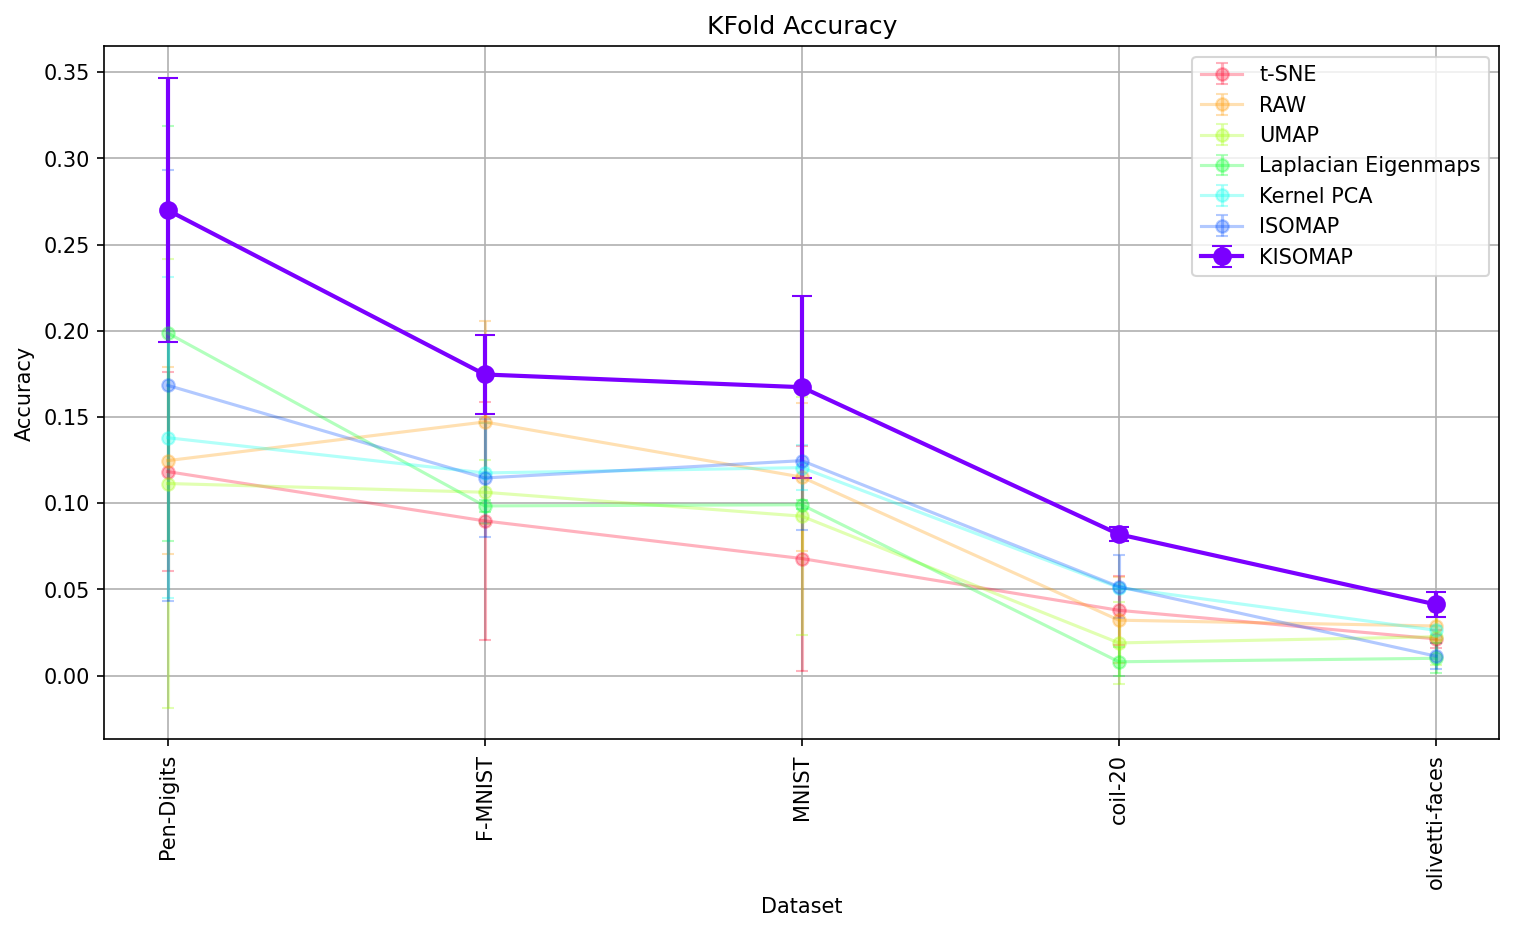

In [20]:
import matplotlib.pyplot as plt

# Definir as cores para cada método usando o colormap 'Rainbow'
colormap = plt.get_cmap('gist_rainbow')
methods = df['Method'].unique()
colors = {method: colormap(i / len(methods)) for i, method in enumerate(methods)}

# Criar a figura com tamanho e DPI ajustados
plt.figure(figsize=(12, 6), dpi=150)

# Plotar o gráfico de linhas para cada método com cores definidas
for method in df['Method'].unique():
    subset = df[df['Method'] == method]
    if method == 'KISOMAP':
            plt.errorbar(subset['Dataset'], subset['Mean'], yerr=subset['Std'], 
                         marker='o', label=method, color=colors[method], capsize=5, linewidth=2, markersize=8)
    else:
        plt.errorbar(subset['Dataset'], subset['Mean'], yerr=subset['Std'], 
                     marker='o', label=method, color=colors.get(method, 'gray'), capsize=3, alpha=0.3)

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('KFold Accuracy')
plt.legend()  # Adiciona a legenda
plt.grid(True)
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x se necessário
plt.show()

In [ ]:
import matplotlib.pyplot as plt



# Definir as cores para cada método usando o colormap 'Rainbow'
colormap = plt.get_cmap('gist_rainbow')
methods = df['Method'].unique()
colors = {method: colormap(i / len(methods)) for i, method in enumerate(methods)}

# Criar a figura com tamanho e DPI ajustados
plt.figure(figsize=(12, 6), dpi=150)

# Plotar o gráfico de linhas para cada método com cores definidas
for method in df['Method'].unique():
    subset = df[df['Method'] == method]
    if method == 'KISOMAP':
            plt.line(subset['Dataset'], subset['Mean'], yerr=subset['Std'], 
                         marker='o', label=method, color=colors[method], capsize=5, linewidth=2, markersize=8)
    else:
        plt.errorbar(subset['Dataset'], subset['Mean'], yerr=subset['Std'], 
                     marker='o', label=method, color=colors.get(method, 'gray'), capsize=3, alpha=0.3)

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('KFold Accuracy')
plt.legend()  # Adiciona a legenda
plt.grid(True)
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x se necessário
plt.show()

In [107]:
mask = df['Dataset'].str.contains('_norm')
df_filtered = df[mask]

In [108]:
df = df_filtered
df

,Dataset,Method,Values,RI,CH,FM,V,S,DB
0,F-MNIST_norm,KISOMAP,"[[0.9680413436123045], [0.43254701629957676], ...",0.968041,0.432547,0.922965,0.924588,0.922032,0.569280
1,F-MNIST_norm,ISOMAP,"[[0.9634427344964897], [0.3496098936594935], [...",0.963443,0.349610,0.909331,0.910851,0.905635,0.561238
2,F-MNIST_norm,Kernel PCA,"[[0.9124053563779161], [0.2018359262875549], [...",0.912405,0.201836,0.825446,0.814944,0.768091,0.780110
3,F-MNIST_norm,t-SNE,"[[1.0], [0.3818670997718122], [1.0], [0.990194...",1.000000,0.381867,1.000000,0.990195,0.935166,0.563946
4,F-MNIST_norm,Laplacian Eigenmaps,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,F-MNIST_norm,UMAP,"[[0.9921372620049503], [1.0], [0.9977716415749...",0.992137,1.000000,0.997772,1.000000,1.000000,0.516610
6,F-MNIST_norm,RAW,"[[0.9560392169286225], [0.024138122800206118],...",0.956039,0.024138,0.954724,0.955647,0.736565,1.000000
7,blood-transfusion_norm,KISOMAP,"[[1.0], [1.0], [1.0], [0.9666147033126266], [1...",1.000000,1.000000,1.000000,0.966615,1.000000,0.804595
8,blood-transfusion_norm,ISOMAP,"[[0.6168674698795176], [0.12347577810919141], ...",0.616867,0.123476,0.540820,0.084616,0.384976,0.468885
9,blood-transfusion_norm,Kernel PCA,"[[0.0], [0.09860197360192861], [0.046200731916...",0.000000,0.098602,0.046201,0.708721,0.281276,0.715218


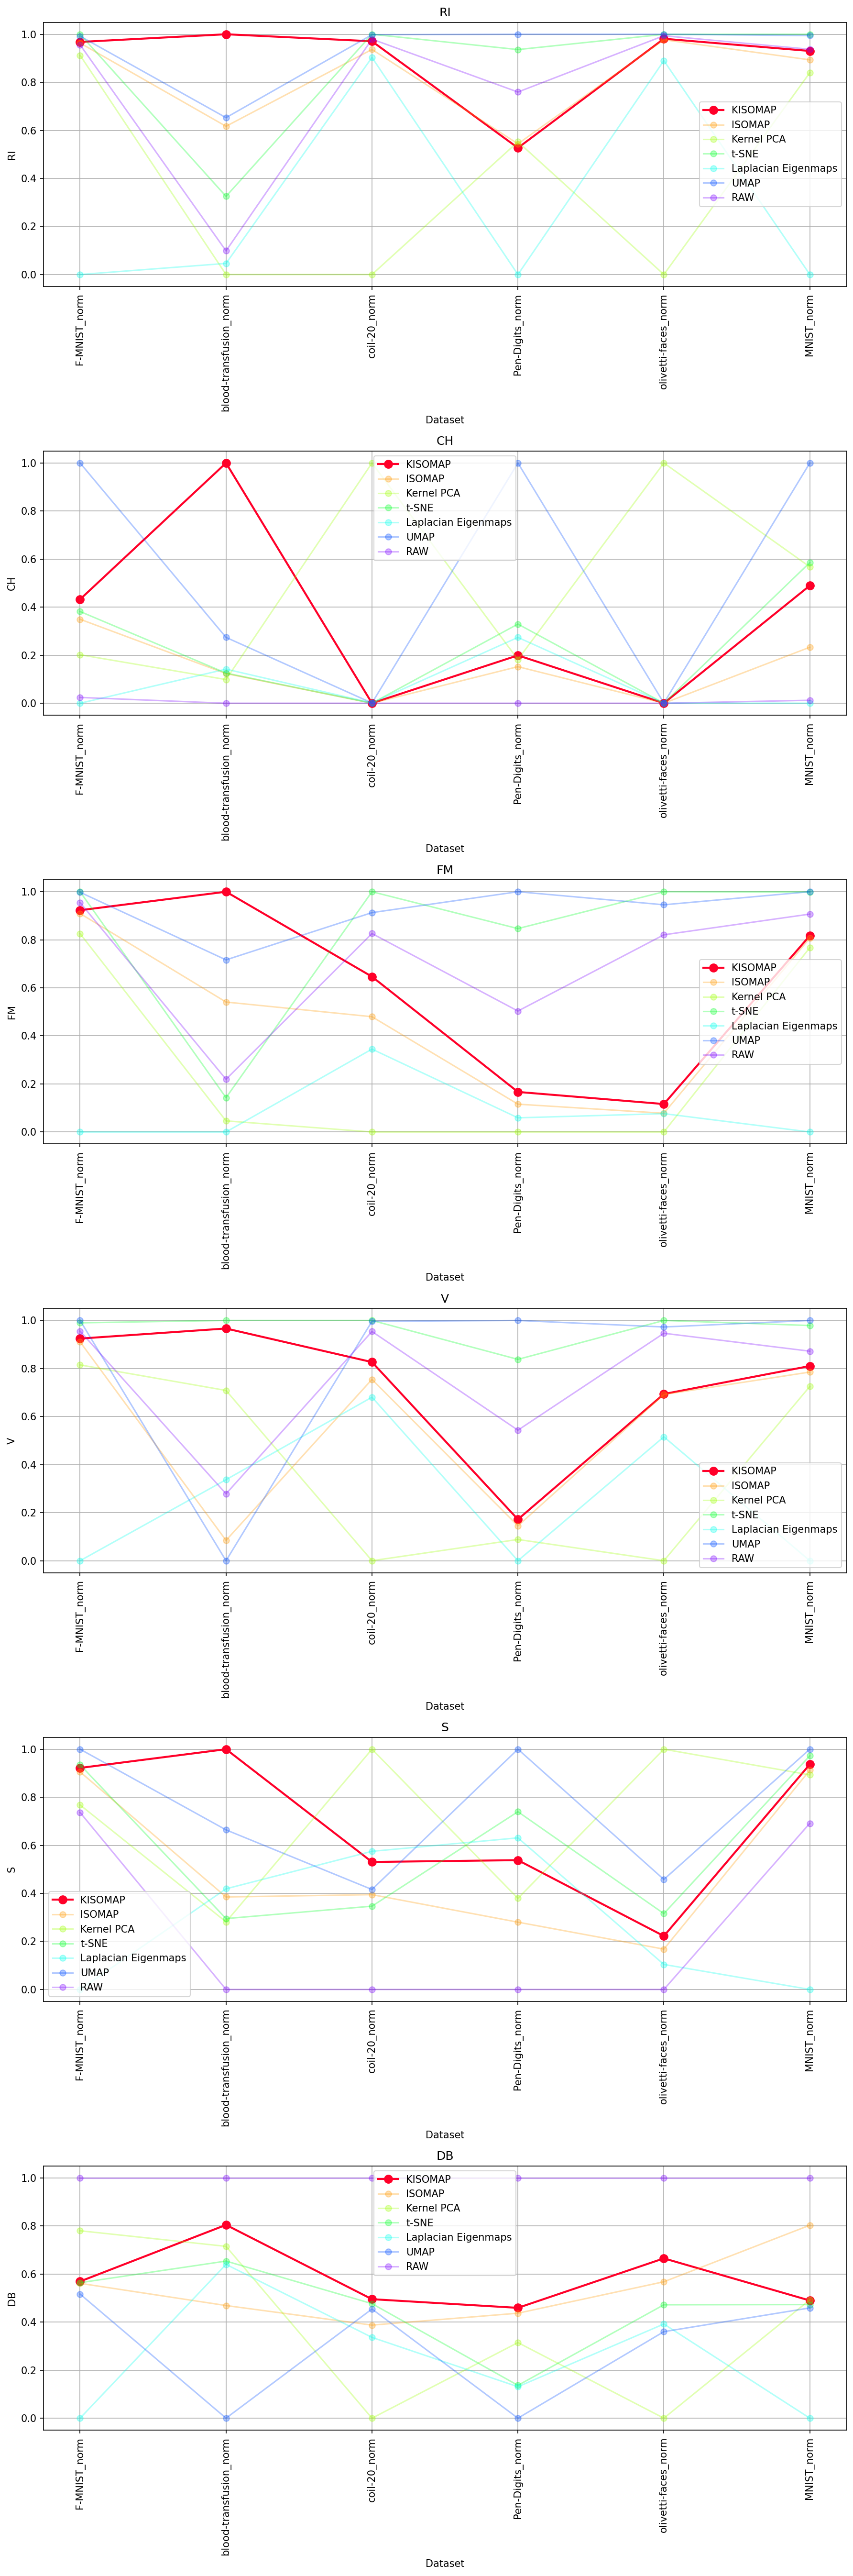

In [109]:
import matplotlib.pyplot as plt

# Definir as cores para cada método usando o colormap 'gist_rainbow'
colormap = plt.get_cmap('gist_rainbow')
methods = df['Method'].unique()
colors = {method: colormap(i / len(methods)) for i, method in enumerate(methods)}

# Lista das novas colunas que serão plotadas
metrics = ['RI', 'CH', 'FM', 'V', 'S', 'DB']

# Criar a figura com subplots, ajustando o tamanho e DPI
fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 6 * len(metrics)), dpi=150)

for ax, metric in zip(axs, metrics):
    for method in df['Method'].unique():
        subset = df[df['Method'] == method]
        if method == 'KISOMAP':
            ax.plot(subset['Dataset'], subset[metric], 
                    marker='o', label=method, color=colors[method], linewidth=2, markersize=8)
        else:
            ax.plot(subset['Dataset'], subset[metric], 
                    marker='o', label=method, color=colors.get(method, 'gray'), alpha=0.3)
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.grid(True)
    ax.legend()  # Adiciona a legenda
    ax.tick_params(axis='x', rotation=90)  # Rotaciona os rótulos do eixo x se necessário

plt.tight_layout()
plt.show()


In [103]:
subset

,Dataset,Method,Values
0,F-MNIST_norm,KISOMAP,"[[0.9680413436123045], [0.43254701629957676], ..."
7,blood-transfusion_norm,KISOMAP,"[[1.0], [1.0], [1.0], [0.9666147033126266], [1..."
14,coil-20_norm,KISOMAP,"[[0.9708018154311648], [0.00025210501303249004..."
28,Pen-Digits_norm,KISOMAP,"[[0.5270105277707386], [0.19929424461729725], ..."
42,olivetti-faces_norm,KISOMAP,"[[0.981328474782142], [0.00025552271218176695]..."
49,MNIST_norm,KISOMAP,"[[0.9304570429510001], [0.489690438379238], [0..."


# Adicionar outliers

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Função para adicionar outliers
def add_outliers(data, num_outliers, outlier_factor=10):
    outliers = np.random.randn(num_outliers, data.shape[1]) * outlier_factor
    return outliers

# Função para calcular centroides de cada classe
def calculate_centroids(data, labels):
    unique_labels = np.unique(labels)
    centroids = []
    for label in unique_labels:
        class_data = data[labels == label]
        centroid = np.mean(class_data, axis=0)
        centroids.append(centroid)
    return np.array(centroids)

# Função para atribuir rótulos aos outliers
def assign_labels_to_outliers(outliers, centroids):
    distances = cdist(outliers, centroids)
    closest_centroids = np.argmin(distances, axis=1)
    return closest_centroids

# Dados simulados
np.random.seed(0)
dataset_data = np.random.randn(100, 5)
dataset_target = np.random.randint(0, 3, 100)  # Supondo 3 classes

# Adicionar outliers
num_outliers = 10
outliers = add_outliers(dataset_data, num_outliers)

# Calcular centroides de cada classe
centroids = calculate_centroids(dataset_data, dataset_target)

# Atribuir rótulos aos outliers
outlier_labels = assign_labels_to_outliers(outliers, centroids)

# Combinar dados e rótulos originais com outliers e seus rótulos
augmented_data = np.vstack([dataset_data, outliers])
augmented_labels = np.hstack([dataset_target, outlier_labels])

print("Dados aumentados:", augmented_data)
print("Rótulos aumentados:", augmented_labels)

Dados aumentados: [[ 1.76405235e+00  4.00157208e-01  9.78737984e-01  2.24089320e+00
   1.86755799e+00]
 [-9.77277880e-01  9.50088418e-01 -1.51357208e-01 -1.03218852e-01
   4.10598502e-01]
 [ 1.44043571e-01  1.45427351e+00  7.61037725e-01  1.21675016e-01
   4.43863233e-01]
 [ 3.33674327e-01  1.49407907e+00 -2.05158264e-01  3.13067702e-01
  -8.54095739e-01]
 [-2.55298982e+00  6.53618595e-01  8.64436199e-01 -7.42165020e-01
   2.26975462e+00]
 [-1.45436567e+00  4.57585173e-02 -1.87183850e-01  1.53277921e+00
   1.46935877e+00]
 [ 1.54947426e-01  3.78162520e-01 -8.87785748e-01 -1.98079647e+00
  -3.47912149e-01]
 [ 1.56348969e-01  1.23029068e+00  1.20237985e+00 -3.87326817e-01
  -3.02302751e-01]
 [-1.04855297e+00 -1.42001794e+00 -1.70627019e+00  1.95077540e+00
  -5.09652182e-01]
 [-4.38074302e-01 -1.25279536e+00  7.77490356e-01 -1.61389785e+00
  -2.12740280e-01]
 [-8.95466561e-01  3.86902498e-01 -5.10805138e-01 -1.18063218e+00
  -2.81822283e-02]
 [ 4.28331871e-01  6.65172224e-02  3.02471898e-

In [21]:
model = LocallyLinearEmbedding(n_neighbors=nn, n_components=d_star, method = 'ltsa')
LTSA_data = model.fit_transform(dataset_data)
LTSA_data = LTSA_data.T
DR_method = 'LTSA ' + dataset_name + ' cluster=' + CLUSTER
L_LTSA = Clustering(LTSA_data, dataset_target, DR_method, CLUSTER)

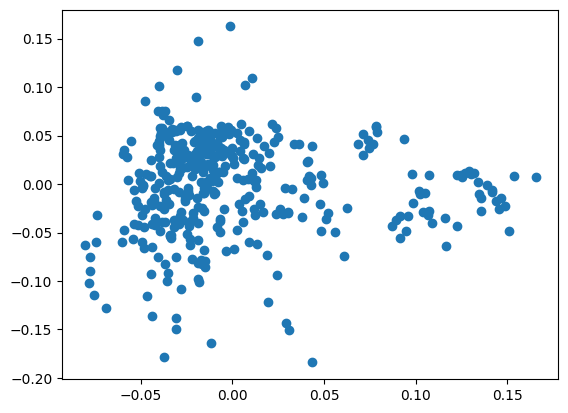

In [22]:
plt.scatter(x=LTSA_data[0],y=LTSA_data[1])
plt.show()

In [23]:
L_LTSA

[0.39895989974937346,
 47.52035093136288,
 0.16912354990458528,
 0.30041381018401975,
 0.3667795927574678,
 1.8890066455522387,
 array([ 4, -1,  4, -1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  2,  2,  2,  2, -1,  2,  2,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4, -1, -1, -1, -1, -1, -1, -1,  4, -1, -1,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4, -1, -1,  4,  4, -1,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, -1,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4, 